In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
import os
import cv2
import imageio
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from os.path import splitext, basename
import matplotlib.pyplot as pl
# %matplotlib

# split original videos

In [3]:
def single_video_frames(video):
    frames = []
    if os.path.splitext(video)[-1] != '.mov':
        cap = cv2.VideoCapture(video)
        frame_nb = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        i =  0
        while i<frame_nb:
            ret, frame = cap.read()
            if not ret:
                frames.append(np.zeros_like(frames[i-1]))
                print(i)
            else:
                frames.append(frame[:,:,::-1])
            i+=1
        cap.release()
    else:
        reader = imageio.get_reader(video)
        frames = [frame for frame in reader]
        reader.close()
    return np.asarray(frames)

In [4]:
def all_replay_videos():
    videos = [replay_videos(folder) for folder in ['train','devel','test']]
    return sum(videos,[])

def replay_videos(subfoloder='devel'):
    '''
    subfolder only accept one of ['train','test','devel']'''
    real = 'E:/Xuhang/DataSet/ReplayAttackDatabase/replayattack-{}/{}/real/*.mov'.format(subfoloder,subfoloder)
    fixd = 'E:/Xuhang/DataSet/ReplayAttackDatabase/replayattack-{}/{}/attack/fixed/*.mov'.format(subfoloder,subfoloder)
    hand = 'E:/Xuhang/DataSet/ReplayAttackDatabase/replayattack-{}/{}/attack/hand/*.mov'.format(subfoloder,subfoloder)
    return sum([glob(real),glob(fixd),glob(hand)],[])

In [5]:
class Crop_face():
    '''
    this class is for recording face crop coordinates and crop_ratio of each sequence
    -video name
    -frame_nb: how many frames each mini face video will contain
    -sub_video_nb: how many sub_video will be extracted
    -sample_rate: interval of each sampled two frames
    -suffix: if replayattack database 'mov', else 'avi'
    '''
    def __init__(self,video_name,frame_nb,sub_folder,video_list,sub_video_nb,sample_rate=1,suffix='mov'):
        self.video_name = video_name
        self.video_list = video_list
        self.frame_nb = frame_nb
        self.sub_video_nb = sub_video_nb
        self.sample_rate = sample_rate
        self.seed = 1994
        self.sub_folder = sub_folder
        self.face_name = self.video_name.replace('.{}'.format(suffix),'.face')

    def single_video_landmarks(self):
        '''
        order: top-left-bottom-right
        '''
        df = pd.read_csv(self.face_name,header=None,delim_whitespace=True,names=['idx','left','top','width','height'])
        face = pd.concat([df.top,df.left,df.top+df.height,df.left+df.width],axis=1).to_numpy()
        return face
    
    def start_idx_of_input_frames(self):
        '''
        based on -sub_video_nb parameter, choose all first frame indexes, total number is sub_video_nb        
        '''
        coords = self.single_video_landmarks()
        
        # first limite first-frame choose range between first non-zero landmark frame to total_frames-frame_nb
        
        # detect first non-zero landmark frame
        i = 0
        while i<len(coords):
            if coords[i].any():
                break
            else:
                i += 1
                
        start_idx = i
        candi_idxs = list(np.arange(start_idx,coords.shape[0]-self.frame_nb*self.sample_rate))
        
        # filter these frames that detect no face 
        candi_idxs = [idx for idx in candi_idxs if coords[idx:idx+self.frame_nb].any()]
        
        replace = True if len(candi_idxs)<=self.sub_video_nb else False
        
        np.random.seed(1994)
        start_idx = np.random.choice(candi_idxs,self.sub_video_nb,replace=replace)
        
        return start_idx
    
    def chunk_face_ldmk(self,chunk):
        '''
        based on chunk frames face landmarks, find minimum value of top-left 
        meanwhile find maximum value of bottom-right corner
        '''
        # filter landmarks in this chunk which can not detect face
        coords = np.array(list(filter(lambda x:x.any(), chunk)))
        top, left = np.min(coords[:,0]),np.min(coords[:,1])
        bottom,right = np.max(coords[:,2]),np.max(coords[:,3])
        return top,left,bottom,right
    
    
    def idx_loop(self):
        '''
        main part of this class, extract enough start frame index and coordinates of that chunk
        '''
        vd_idx = self.video_list.index(self.video_name)
        label = 0 if 'Real' in self.video_name or 'real' in self.video_name else 1
        
        # find all reasonable start frame index
        start_idxs = self.start_idx_of_input_frames()
        
        # unpack face landmarks
        ldmarks = self.single_video_landmarks()
        
        info = []
        for start_idx in start_idxs:
            # choosed frame indexs in a chunk
            choose_frames_idxs = [start_idx+int(idx*self.sample_rate) for idx in range(self.frame_nb)]
            # face landmakrs of each choose frame
            choose_frames_ldmk = ldmarks[choose_frames_idxs]
            # minimum value of top-left and maximum value of bottom-right corner
            chunk_ldmk = self.chunk_face_ldmk(chunk=choose_frames_ldmk)
            info.append([self.sub_folder,'{:04}'.format(vd_idx),label,start_idx,chunk_ldmk[0],chunk_ldmk[1],chunk_ldmk[2],chunk_ldmk[-1]])
        return info

def save_to_csv(*args):
    '''
    -save_path
    -frame_nb
    -sample_rate
    '''
    save_path,frame_nb,sample_rate = args
    if not os.path.exists(save_path): os.makedirs(save_path)
        
    videos = all_replay_videos()
    videos_df = pd.DataFrame(videos)
    videos_df.to_csv('replayattack_video_names_NO_EDITTING.csv')
    
    save_name = '{}/frames_{}_interval_{}'.format(save_path,frame_nb,sample_rate)
    info_df = pd.DataFrame(columns=['sub_folder','video_index','real_spoof','start_idx','top','left','bottom','right'])
    for video in tqdm(videos):
        sub_video_nb = 100 if 'train_Real' in video else 20
        sub_folder = 'train' if 'train' in video else 'test' if 'test' in video else 'devel'
        crop = Crop_face(video_name=video,frame_nb=frame_nb,
                         sub_folder=sub_folder,video_list=videos,
                         sub_video_nb=sub_video_nb,
                         sample_rate=sample_rate)
        info = crop.idx_loop()
        info = pd.DataFrame(info,columns=info_df.columns)
        info_df = info_df.append(info)
    info_df.to_csv(save_name+'.csv')

In [286]:
for frame_nb in [4,6,8,10]:
    save_to_csv('./replayattack-baseline/',frame_nb,1)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 74.76it/s]


In [6]:
save_to_csv('./replayattack-baseline/',12,1)

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:24<00:00, 48.28it/s]


# to tfrecord

把视频地址编码存入CSV文件---Done!

打乱训练集
    -先提取每个csv文件的trainset的数据
    -打乱训练集数据：分为两个阶段，第一阶段依据视频所属标签，第二阶段依据视频真假

In [105]:
def data_to_tfrecord(total_video_crop_csv,to_file=None):
    """for each csv file contains train,test,devel information we write tfrecord of each subset, 
    first shuffle each subset, then in each subset write tfrecord line by line"""
    def _pd_shuffle(df,sub_folder,seed=1994):
        return df[df.sub_folder==sub_folder].sample(frac=1,random_state=seed)
    
    """
    extract key information, 
    frame_nb represents how many frames will be extracted in in each data point
    interval represents the gap between two sampled frames
    """
    frame_nb = int(basename(total_video_crop_csv).split('_')[1])
    interval = int(basename(total_video_crop_csv).split('_')[-1].split('.')[0])
    
    df = pd.read_csv(total_video_crop_csv)
    
    
    for subset_flag in ['train','devel','test']:
        """shuffle"""
        shuffled_subset = _pd_shuffle(df,subset_flag)
        """write a tfrecord of each subset"""
        subset_to_tfrecord(subset=shuffled_subset,
                           subset_flag=subset_flag,
                           frame_nb=frame_nb,
                           interval=interval,
                           to_file=to_file)

def subset_to_tfrecord(subset,
                       subset_flag,
                       frame_nb,
                       interval,
                       total_vdname_csv=None,
                       to_file=None,
                       cvt_format=None,
                       temp_length=None):
    """iterate over one of train test and devel set to get tfrecord,
        subset shold be shuffled already with a type of pd.Dataframe"""
    
    if total_vdname_csv==None: 
        total_vdname_csv = 'E:/Xuhang/code/Graduation/replayattack_video_names_NO_EDITTING.csv'
        
    if to_file==None: to_file = 'E:/Xuhang/code/Graduation/replayattack-baseline/'
    
    if cvt_format==None: cvt_frmat='.jpg'
        
    video_list = list(pd.read_csv(total_vdname_csv).iloc[:,1].to_numpy())
    
    sample_nb = subset.shape[0] if temp_length is None else temp_length
    
    save_file = to_file+'frames-{}-{}-interval-{}-{}.tfrecord'.format(frame_nb,subset_flag,interval,sample_nb)
    
    with tf.python_io.TFRecordWriter(save_file) as writer: 
        for i in tqdm(range(sample_nb)):
            line = subset.iloc[i]
            video_name = video_list[int(line.video_index)]
            line_example = line_to_example(line=line,
                                          video_name=video_name,
                                          frame_nb=frame_nb,
                                          interval=interval,
                                          cvt_fmt=cvt_format)
            writer.write(line_example)
        writer.close()

def line_to_example(line,video_name,frame_nb,cvt_fmt,interval):
    """cvt one row of Dataframe to tfrecord serialized example"""
    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
    
    def read_by_opencv(video_name,start_idx,frame_nb,interval):
        cap = cv2.VideoCapture(video_name)
        cap.set(cv2.CAP_PROP_POS_FRAMES,start_idx)
        i,frames = 0,[]
        while i < frame_nb:
            ret, frame = cap.read()
            i += 1
            if i%interval==0:frames.append(frame[:,:,::-1])
        cap.release()
        return np.asarray(frames)
    
    def read_by_imageio(video_name,start_idx,frame_nb,interval):
        reader = imageio.get_reader(video_name)
        frames = [reader.get_data(i) for i in range(start_idx,start_idx+frame_nb*interval,interval)]
        reader.close()
        return np.asarray(frames)
    
    """read video by start frame and extract frames by interval"""
    def read_video_by_start_idx(video_name,start_idx,frame_nb,interval):
        if '.mov' in video_name:
            return read_by_imageio(video_name,start_idx,frame_nb,interval)
        else:
            try:
                # cv2 read video faster than imageio but cv2 is not that stable
                frames = read_by_opencv(video_name,start_idx,frame_nb,interval)
            except:
                frames = read_by_imageio(video_name,start_idx,frame_nb,interval)
        return np.asarray(frames)
    
    """convert information of each row from csv_file as tfrecord sample"""
    frames = read_video_by_start_idx(video_name,line.start_idx,frame_nb,interval)
    top,left,bottom,right = line.top,line.left,line.bottom,line.right
    chunk_faces = frames[:,top:bottom,left:right]
    
    
    line_feature = {}
    line_feature['height'] = _int64_feature(chunk_faces.shape[1])
    line_feature['width'] = _int64_feature(chunk_faces.shape[2])
    line_feature['depth'] = _int64_feature(chunk_faces.shape[3])
    line_feature['video_index'] = _int64_feature(int(line.video_index))
    line_feature['start_idx'] = _int64_feature(line.start_idx)
    line_feature['label'] = _int64_feature(line.real_spoof)
    for count, face in enumerate(chunk_faces):
        face_raw = face.tostring()
        line_feature['frame/{:04d}'.format(count)] = _bytes_feature(face_raw)
    
    example = tf.train.Example(features=tf.train.Features(feature=line_feature))
    return example.SerializeToString()

In [ ]:
data_to_tfrecord(total_video_crop_csv='replayattack-baseline/frames_4_interval_1.csv')

In [ ]:
from tfrecord import data_to_tfrecord
data_to_tfrecord(total_video_crop_csv='replayattack-baseline/frames_12_interval_1.csv')

# Decode

In [36]:
def _decode_fn(filenames,
               frame_nb=10,
               batch_size=1,
               normalize=False,
               perform_shuffle=False, 
               repeat_count=None,
               one_hot=False,
               n_class=2):
    '''
    input:  filenames--tfrecord file name
            perform_shuffle--True means shuffle, False means no shuffle
            repeat_count--interger, repeat times in an epoch through the whole dataset, if None, forever loop through dataset
            batch_size--no need to explain
            fp_name--face points, only accept parameters from list of ['left_eye','right_eye','nose','left_mouth_corner','right_mouth_corner']
    output: an tuple, has three values which are labels, facial points and video sequences
            shape is (labels, facial pints, video sequences)
            for each output, shape is (batch_size, XX.shape), XX means one of labels, fpoints and video sequences
    '''
    
    
    def decode_fn(serialized_example):
        line_feature = {}
        line_feature['label'] = tf.FixedLenFeature([], tf.int64)
        line_feature['height'] = tf.FixedLenFeature([], tf.int64)
        line_feature['width'] = tf.FixedLenFeature([], tf.int64)
        line_feature['depth'] = tf.FixedLenFeature([], tf.int64)
        for count in range(frame_nb):
            line_feature['frame/{:04d}'.format(count)] = tf.FixedLenFeature([],tf.string)

        parsed_features = tf.parse_single_example(serialized_example, line_feature)

        label = parsed_features['label']
        height = parsed_features['height']
        width = parsed_features['width']
        depth = parsed_features['depth']
        
        face_images = [tf.decode_raw(parsed_features['frame/{:04d}'.format(count)],tf.uint8) for count in range(frame_nb)]
        face_images = [tf.reshape(face,[height,width,depth]) for face in face_images]
        face_images = [tf.image.resize(face,(128,128),method=1) for face in face_images]

        if one_hot and n_class: label = tf.one_hot(label,n_class)
        return face_images, label

    dataset = tf.data.TFRecordDataset(filenames=filenames)
    
    dataset = dataset.map(decode_fn)
    if perform_shuffle: dataset = dataset.shuffle(buffer_size=calculate_filenb(filenames))
    dataset = dataset.repeat(repeat_count)
    dataset = dataset.batch(batch_size)  # Batch size to use
    dataset = dataset.prefetch(8)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

In [37]:
tfrecord = 'replayattack-baseline/frames-4-train-interval-1-100.tfrecord'

In [38]:
func = _decode_fn(filenames=tfrecord,frame_nb=4,batch_size=32,repeat_count=1,one_hot=True)

In [39]:
sess = tf.Session()

In [40]:
faces, labels = sess.run(func)

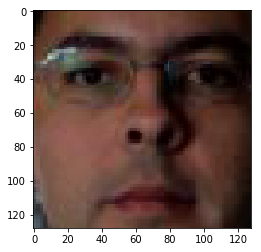

In [41]:
pl.imshow(faces[1][1])

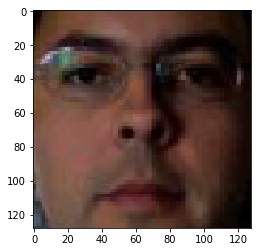

In [52]:
pl.imshow(faces[8][1])